# Exploring the *Titanic* dataset with `seaborn`

Kaggle has a nice [dataset](https://www.kaggle.com/c/titanic-gettingStarted)
with information about passengers on the *Titanic*. It's meant as an
introduction to predictive models -- here, predicting who survived the
sinking. Let's explore it using
[seaborn](http://stanford.edu/~mwaskom/software/seaborn/).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="white")

First we load in the data and take a look

In [2]:
url = "https://raw.github.com/mattdelhey/kaggle-titanic/master/Data/train.csv"
titanic = pd.read_csv(url)
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    int64  
 2   name      891 non-null    object 
 3   sex       891 non-null    object 
 4   age       714 non-null    float64
 5   sibsp     891 non-null    int64  
 6   parch     891 non-null    int64  
 7   ticket    891 non-null    object 
 8   fare      891 non-null    float64
 9   cabin     204 non-null    object 
 10  embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [3]:
titanic.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Let's do  little bit of processing to make some different variables that
might be more interesting to plot. Since this notebook is focused on
visualization, we're going to do this without much comment.

In [4]:
def woman_child_or_man(passenger):
    age, sex = passenger
    if age < 16:
        return "child"
    else:
        return dict(male="man", female="woman")[sex]

In [5]:
titanic["class"] = titanic.pclass.map({1: "First", 2: "Second", 3: "Third"})
titanic["who"] = titanic[["age", "sex"]].apply(woman_child_or_man, axis=1)
titanic["adult_male"] = titanic.who == "man"
titanic["deck"] = titanic.cabin.str[0].map(lambda s: np.nan if s == "T" else s)
titanic["embark_town"] = titanic.embarked.map({
    "C": "Cherbourg",
    "Q": "Queenstown",
    "S": "Southampton"
})
titanic["alive"] = titanic.survived.map({0: "no", 1: "yes"})
titanic["alone"] = ~(titanic.parch + titanic.sibsp).astype(bool)
titanic = titanic.drop(["name", "ticket", "cabin"], axis=1)

Set categorical values

In [6]:
titanic.describe(include='object')

,sex,embarked,class,who,deck,embark_town,alive
count,891,889,891,891,203,889,891
unique,2,3,3,3,7,3,2
top,male,S,Third,man,C,Southampton,no
freq,577,644,491,537,59,644,549


Change types to categorical

In [7]:
cat_sex = pd.Categorical(titanic.sex,
                         categories=['male', 'female'],
                         ordered=True)
titanic['sex'] = cat_sex

In [8]:
cat_embark_town = titanic.embark_town.astype('category')
titanic['embark_town'] = cat_embark_town

In [9]:
cat_class = pd.Categorical(titanic['class'],
                           categories=['First', 'Second', 'Third'],
                           ordered=True)
titanic['class'] = cat_class

In [10]:
cat_who = pd.Categorical(titanic.who,
                         categories=['man', 'woman', 'child'],
                         ordered=True)
titanic['who'] = cat_who

In [11]:
cat_deck = pd.Categorical(titanic.deck,
                          categories=['A', 'B', 'C', 'D', 'E', 'F', 'G'],
                          ordered=True)
titanic['deck'] = cat_deck

In [12]:
titanic.dtypes

survived          int64
pclass            int64
sex            category
age             float64
sibsp             int64
parch             int64
fare            float64
embarked         object
class          category
who            category
adult_male         bool
deck           category
embark_town    category
alive            object
alone              bool
dtype: object

Finally set up a palette dictionary for some of the plots.

In [13]:
pal = dict(man="#4682B4",
           woman="#CD5C5C",
           child="#2E8B57",
           male="#6495ED",
           female="#F08080")

## Who were the *Titanic* passengers?

Before getting to the main question (who survived), let's take a look at the
dataset to get a sense for how the observations are distributed into the
different levels of our factors of interest.

### How many men, women, and children are in our sample?

First let's count the number of males and females, ignoring age.

<AxesSubplot:xlabel='sex', ylabel='count'>

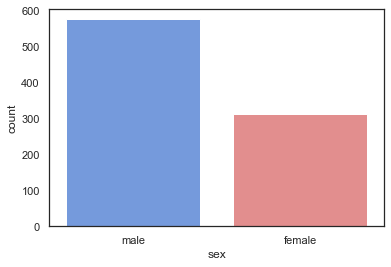

In [14]:
sns.countplot(x="sex", data=titanic, palette=pal)

Then we can look at how this is distributed into the three classes.

<AxesSubplot:xlabel='class', ylabel='count'>

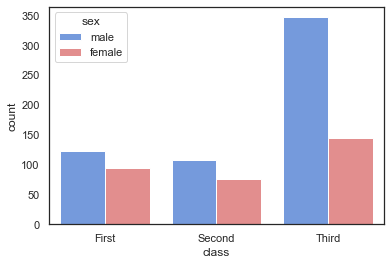

In [15]:
sns.countplot(x="class", data=titanic, hue="sex", palette=pal)

We also have a separate classification that splits off children
(recall, this is going to be relevant because of the "women and children
first" policy followed during the evacuation).

<AxesSubplot:xlabel='who', ylabel='count'>

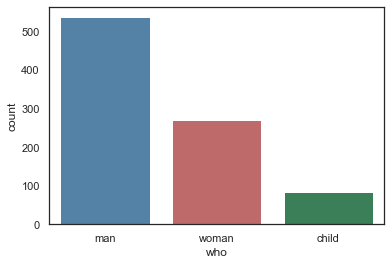

In [16]:
sns.countplot(x="who", data=titanic, palette=pal)

<AxesSubplot:xlabel='class', ylabel='count'>

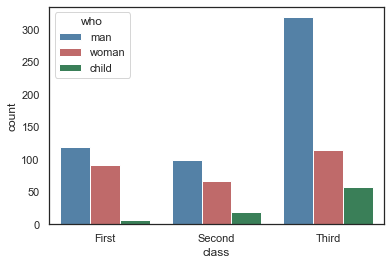

In [17]:
sns.countplot(x="class", data=titanic, hue="who", palette=pal)

Finally, we made a variable that indicates whether a passanger was an
adult male.

<AxesSubplot:xlabel='adult_male', ylabel='count'>

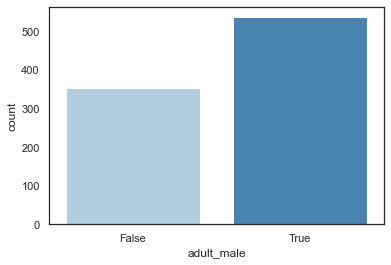

In [18]:
sns.countplot(x="adult_male", data=titanic, palette="Blues")

Next let's look at the distribution of ages within the groups we defined
above.

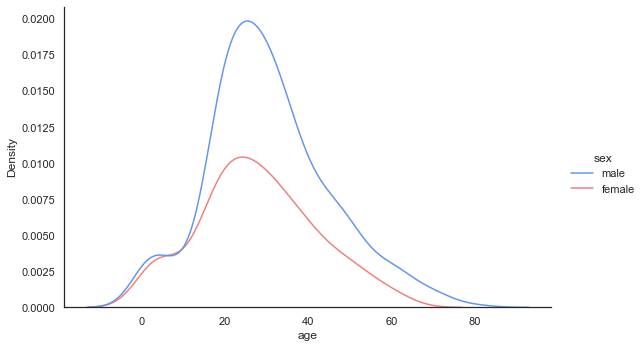

In [19]:
sns.displot(x='age',
            data=titanic,
            hue='sex',
            kind='kde',
            aspect=1.6,
            palette=pal)

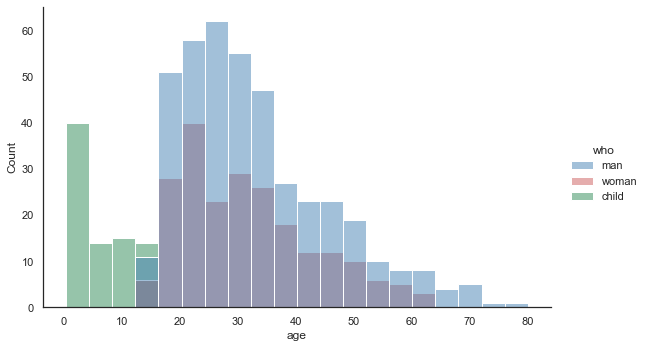

In [20]:
sns.displot(x='age',
            data=titanic,
            hue='who',
            kind='hist',
            aspect=1.6,
            palette=pal)

### How many first, second, and third class passengers are in our sample?

Although have some information about the distribution into classes from the
sex plots, let's directly visualize it an then see how the classes break
down by age.

<AxesSubplot:xlabel='class', ylabel='count'>

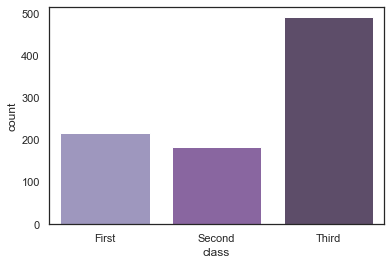

In [21]:
sns.countplot(x='class', data=titanic, palette="BuPu_d")

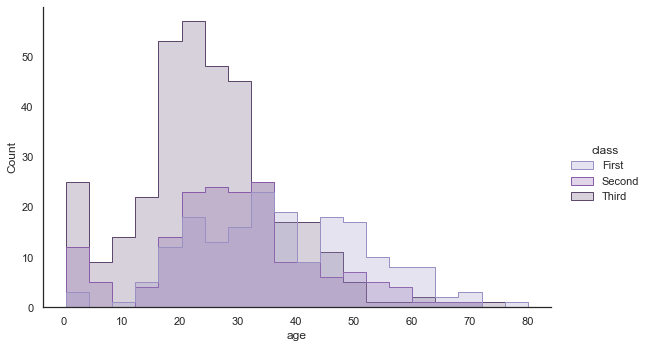

In [22]:
sns.displot(x='age',
            data=titanic,
            hue='class',
            common_norm=False,
            aspect=1.6,
            palette='BuPu_d',
            element='step')

Finally let's look at the breakdown by age and sex.

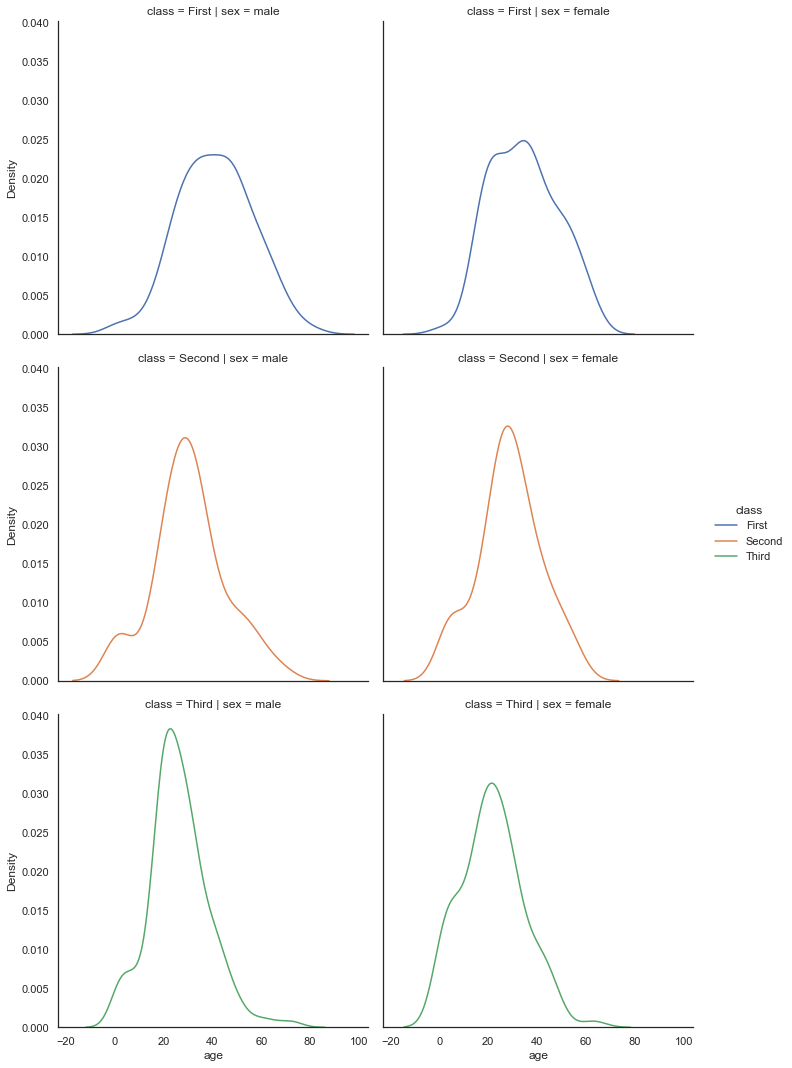

In [23]:
sns.displot(x='age',
            data=titanic,
            hue='class',
            col='sex',
            row='class',
            kind='kde',
            common_norm=False)

### Where were our passenger's cabins?

We also have information about what deck each passgener's cabin was on,
which may be relevant.

<AxesSubplot:xlabel='deck', ylabel='count'>

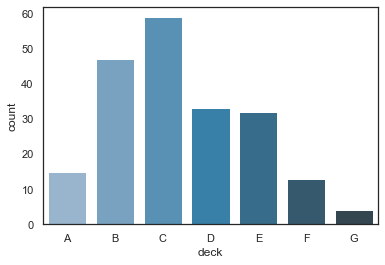

In [24]:
sns.countplot(x="deck", data=titanic, palette="PuBu_d")

How did the decks break down by class for the passengers we have data about?

<AxesSubplot:xlabel='deck', ylabel='count'>

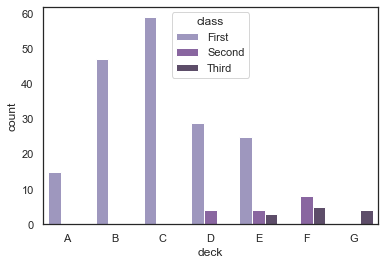

In [25]:
sns.countplot(x="deck", hue="class", data=titanic, palette="BuPu_d")

Note that we're missing a lot of deck data for the second and third class
passengers, which will be important to keep in mind later.

### How much did they pay for their tickets?

Since we have data about fares, let's see how those broke down by classes.

In [26]:
sns.set(style="white")

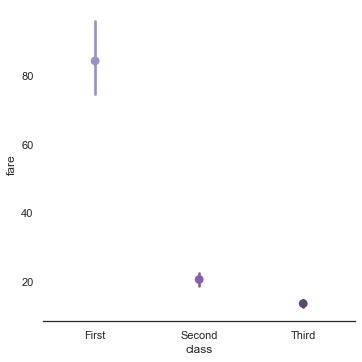

In [27]:
sns.catplot(x="class", y="fare", data=titanic, kind='point', palette="BuPu_d")
sns.despine(left=True)

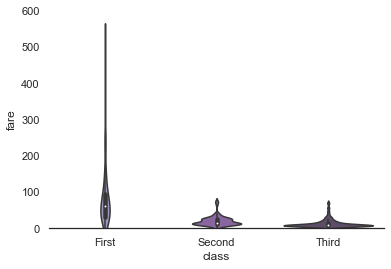

In [28]:
sns.violinplot(x='class', y='fare', data=titanic,
               palette="BuPu_d").set_ylim(0, 600)
sns.despine(left=True)

There are some extreme outliers in the first class distribution; let's
winsorize those to get a better sense for how much each class paid.

In [29]:
titanic["fare_winsor"] = titanic.fare.map(lambda f: min(f, 200))

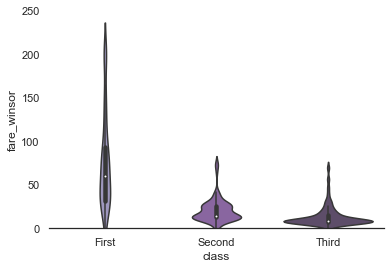

In [30]:
sns.violinplot(x='class', y='fare_winsor', data=titanic,
               palette="BuPu_d").set_ylim(0, 250)
sns.despine(left=True)

How did the fares break down by deck? Let's look both at the mean and the
distribution.

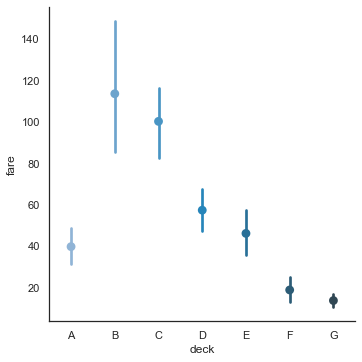

In [31]:
sns.catplot(x="deck", y="fare", data=titanic, kind='point', palette="PuBu_d")

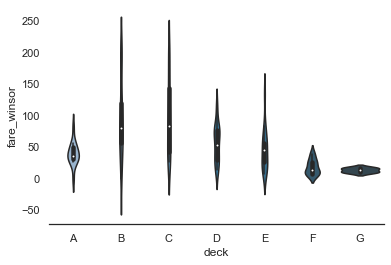

In [32]:
sns.violinplot(x='deck', y='fare_winsor', data=titanic, palette="PuBu_d")
sns.despine(left=True)

It might make more sense to plot the median fare, since the distributions
aren't normal.

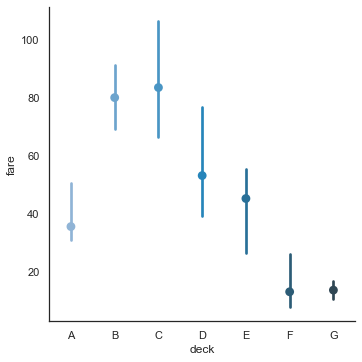

In [33]:
sns.catplot(x="deck",
            y="fare",
            data=titanic,
            palette="PuBu_d",
            estimator=np.median,
            kind='point')

We can also look at a regression of fare on age to see if older passengers
paid more. We'll use robust methods here too, which will accound for the
skewed distribution on fare.

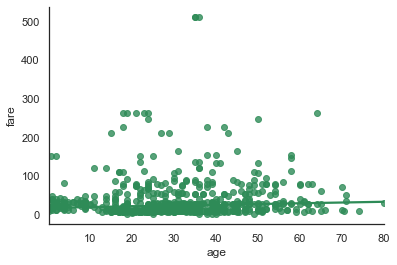

In [34]:
sns.regplot(x="age",
            y="fare",
            data=titanic,
            robust=True,
            ci=None,
            color="seagreen")
sns.despine()

### Where did the passengers come from?

The *Titanic* passengers embarked at one of three ports before the voyage.

<AxesSubplot:xlabel='class', ylabel='count'>

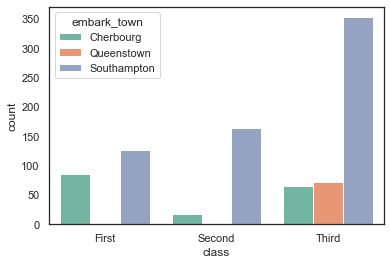

In [35]:
sns.countplot(x="class", data=titanic, hue="embark_town", palette="Set2")

### Who was traveling with family members?

We also have some data, although it's not coded very well, about the number
of parents/children and the numbe of siblings/spouses on board for each
passenger.

<AxesSubplot:xlabel='class', ylabel='count'>

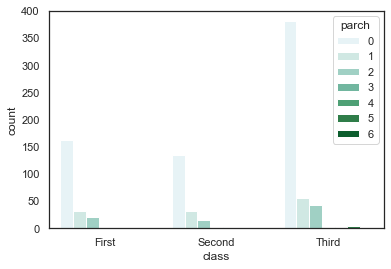

In [36]:
sns.countplot(x="class", data=titanic, hue="parch", palette="BuGn")

<AxesSubplot:xlabel='class', ylabel='count'>

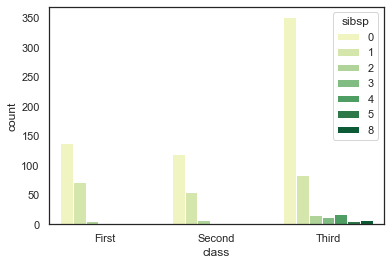

In [37]:
sns.countplot(x="class", data=titanic, hue="sibsp", palette="YlGn")

We defined a variable that just measures whether someone was traveling alone,
i.e. without family.

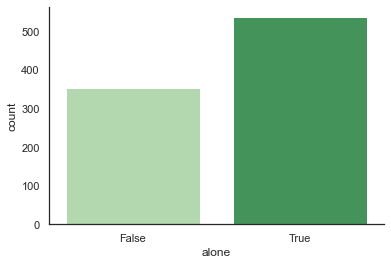

In [38]:
sns.countplot(x="alone", data=titanic, palette="Greens")
sns.despine()

## What made people survive the sinking?

<div style="width:100%; text-align:center">
<i>Iceberg, dead ahead!</i><br><br>
<img src=http://upload.wikimedia.org/wikipedia/en/b/bb/Titanic_breaks_in_half.jpg width=500px>
</div>

Now that we have a feel for the characteristics of our sample, let's get down
to the main question and ask what factors seem to predict whether our
passengers survived. But first, one more count plot just to see how many of
our passengers perished in the sinking.

<AxesSubplot:xlabel='alive', ylabel='count'>

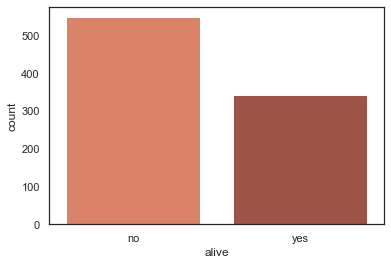

In [39]:
sns.countplot(x="alive", data=titanic, palette="OrRd_d")

### What classes had the survivors traveled in?

It's part of popular lore that the third-class (or steerage) passengers fared
much more poorly than their wealthier shipmates. Is this borne out in the
data?

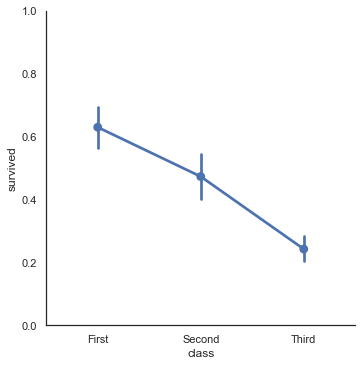

In [40]:
sns.catplot(x="class", y="survived", data=titanic,
            kind='point').set(ylim=(0, 1))

We also of course know that women were given high priority during the
evacuation, and we saw above that Third class was disproportionately male.
Maybe that's driving the class effect?

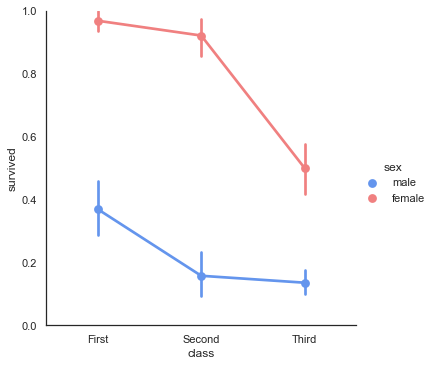

In [41]:
sns.catplot(x="class",
            y="survived",
            data=titanic,
            hue="sex",
            kind='point',
            palette=pal).set(ylim=(0, 1))

Nope, in general it was not good to be a male *or* to be in steerage.

### What effect did "women and children first" have?

Were they at least successful in evacuating the children?

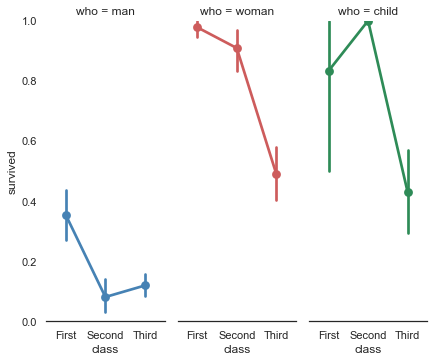

In [42]:
sns.catplot(x="class",
            y="survived",
            data=titanic,
            hue="who",
            col="who",
            kind='point',
            aspect=0.4,
            palette=pal).set(ylim=(0, 1)).despine(left=True)

Pretty good for first and second class (although the precise estimates are
unreliable because there weren't that many children traveling in the upper
classes. It's actually the case that every second-class child survived,
though).

We suspect that the best way to predict survival is to look at whether
a passenger was an adult male and what class he or she was in.

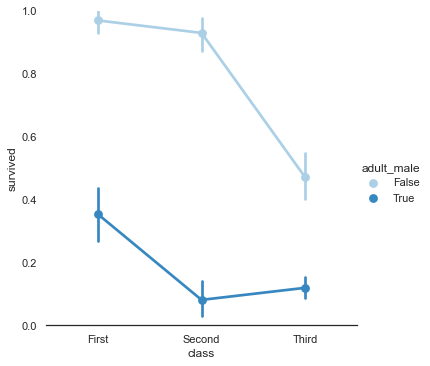

In [43]:
sns.catplot(x="class",
            y="survived",
            data=titanic,
            hue="adult_male",
            palette="Blues",
            kind="point").set(ylim=(0, 1)).despine(left=True)

Another way to plot the same data emphasizes the different outcomes for men
and other passengers even more dramatically.

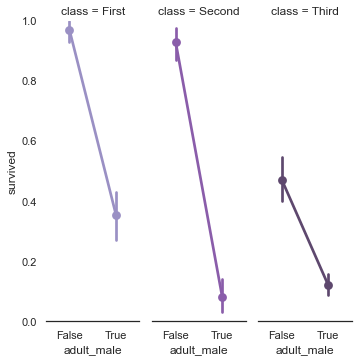

In [44]:
sns.catplot(x="adult_male",
            y="survived",
            data=titanic,
            col="class",
            hue="class",
            palette="BuPu_d",
            kind="point",
            aspect=0.33).set(ylim=(0, 1)).despine(left=True)

### Did age matter in general?

We can also ask whether age as a contiunous variable mattered. We'll draw
logistic regression plots, first jittering the survival datapoints to get
a sense of the distribution.

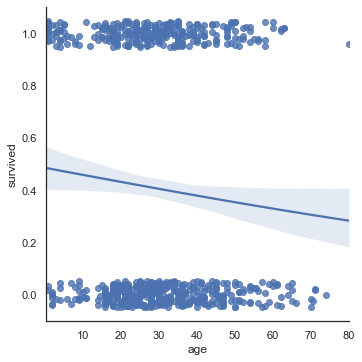

In [45]:
sns.lmplot(x="age", y="survived", data=titanic, logistic=True, y_jitter=.05)

We can also plot the same data with the survival observations grouped into
discrete bins.

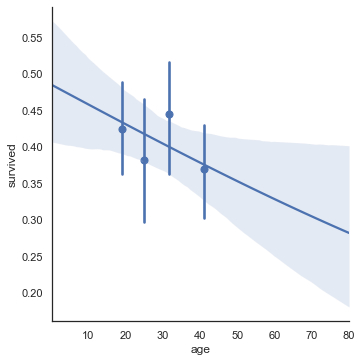

In [46]:
sns.lmplot(x="age",
           y="survived",
           data=titanic,
           logistic=True,
           x_bins=4,
           truncate=True)

### How did age interact with sex and class?

We know that sex is important, though, so we probably want to separate out
these predictions for men and women.

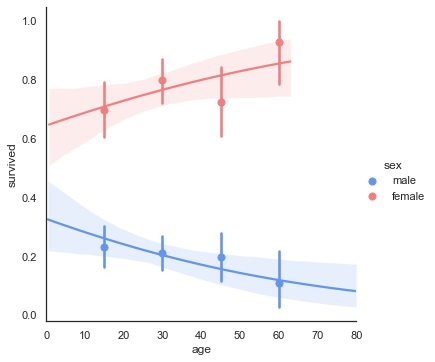

In [47]:
age_bins = [15, 30, 45, 60]
sns.lmplot(x="age",
           y="survived",
           data=titanic,
           hue="sex",
           palette=pal,
           x_bins=age_bins,
           logistic=True).set(xlim=(0, 80))

Class is imporant too, let's see whether it interacts with the age variable
as well.

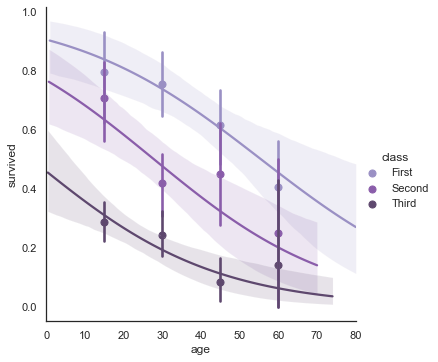

In [48]:
sns.lmplot(x="age",
           y="survived",
           data=titanic,
           hue="class",
           palette="BuPu_d",
           x_bins=age_bins,
           logistic=True).set(xlim=(0, 80))

Because the above plot is rather busy, it might make sense to split the three
classes onto separate facets.

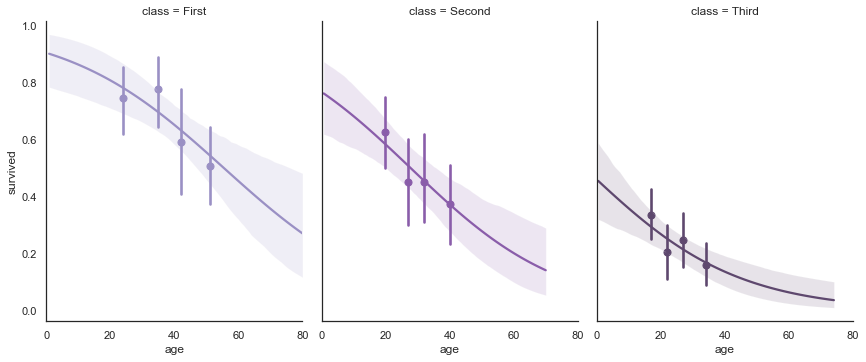

In [49]:
sns.lmplot(x="age",
           y="survived",
           data=titanic,
           col="class",
           hue="class",
           palette="BuPu_d",
           x_bins=4,
           aspect=0.8,
           logistic=True).set(xlim=(0, 80))

### Did it matter what passengers paid, or where they stayed?

We know that class matters, but we can also use the `fare` variable as
a proxy for a contiuous measure of wealth.

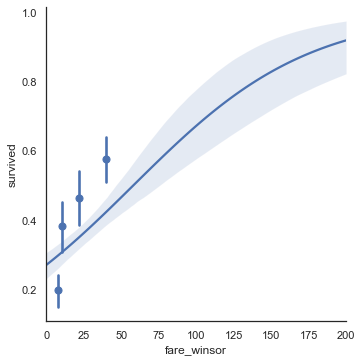

In [50]:
sns.lmplot(x="fare_winsor",
           y="survived",
           data=titanic,
           x_bins=4,
           logistic=True,
           truncate=True)

Perhaps it mattered what deck each passenger's cabin was on?

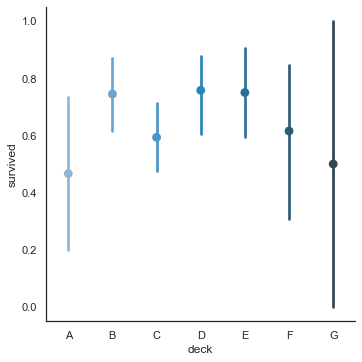

In [51]:
sns.catplot(x="deck",
            y="survived",
            data=titanic,
            kind="point",
            palette="PuBu_d",
            join=False)

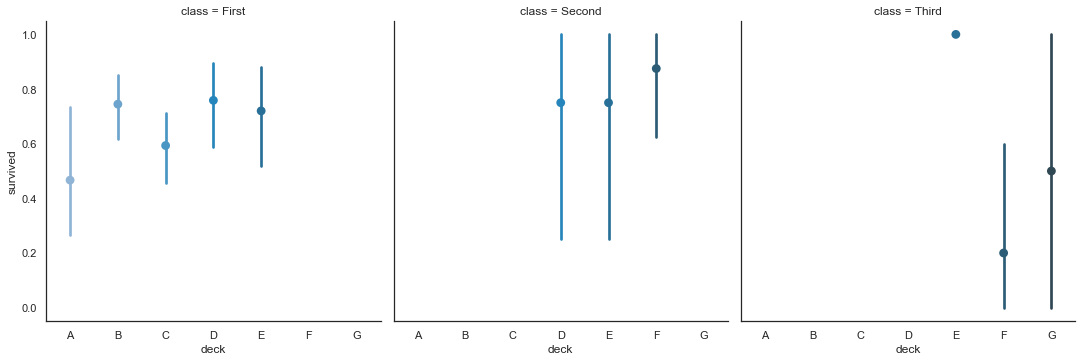

In [52]:
sns.catplot(x="deck",
            y="survived",
            col="class",
            data=titanic,
            kind="point",
            palette="PuBu_d",
            join=False)

### Did family members increase the odds of survival?

Although the way our data on family members was coded, we don't know for sure
what sort of companions these passengers had, but it's worth asking how they
influenced survival.

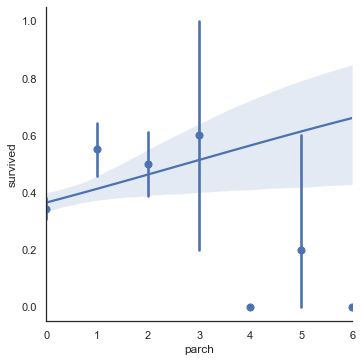

In [53]:
sns.lmplot(x="parch",
           y="survived",
           data=titanic,
           x_estimator=np.mean,
           logistic=True)

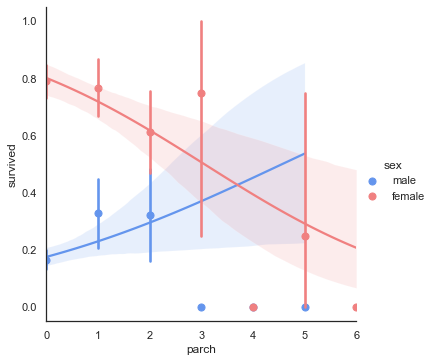

In [54]:
sns.lmplot(x="parch",
           y="survived",
           data=titanic,
           hue="sex",
           x_estimator=np.mean,
           logistic=True,
           palette=pal)

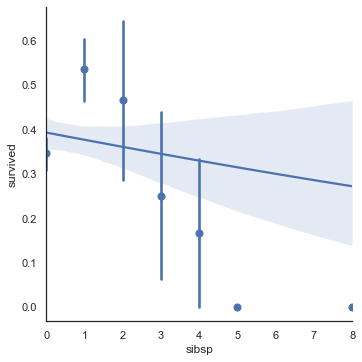

In [55]:
sns.lmplot(x="sibsp",
           y="survived",
           data=titanic,
           x_estimator=np.mean,
           logistic=True)

We also have a more interpretable `alone` variable (although it's reasonable
to assume that this is going to be confounded with age).

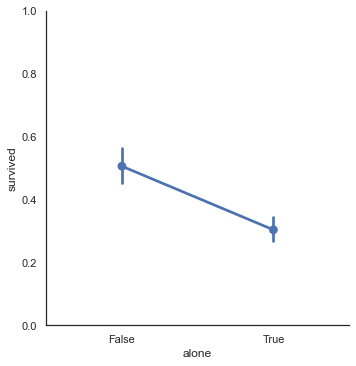

In [56]:
sns.catplot(x="alone", y="survived", data=titanic,
            kind="point").set(ylim=(0, 1))

Did traveling alone have a greater effect depending on what class you were
in?

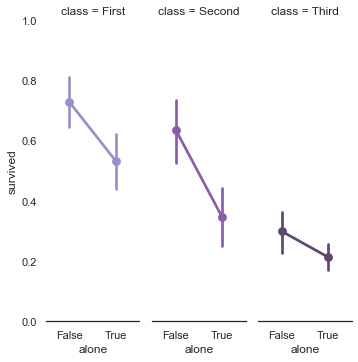

In [57]:
sns.catplot(x="alone",
            y="survived",
            data=titanic,
            col="class",
            hue="class",
            kind="point",
            aspect=0.33,
            palette="BuPu_d").set(ylim=(0, 1)).despine(left=True)

As above, a different presentation of the same data emphasizes different
comparisons.

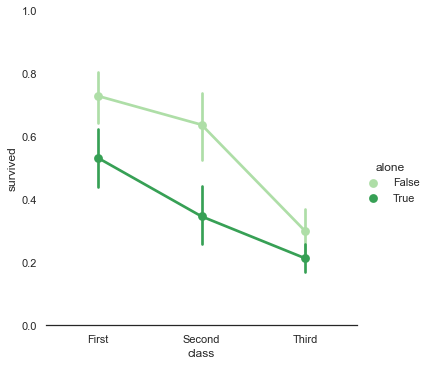

In [58]:
sns.catplot(x="class",
            y="survived",
            data=titanic,
            hue="alone",
            kind="point",
            palette="Greens").set(ylim=(0, 1)).despine(left=True)

What about men and women who were traveling alone?

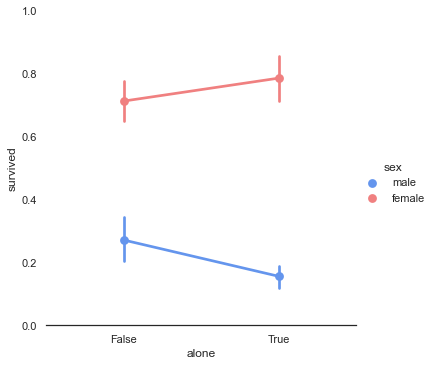

In [60]:
sns.catplot(x="alone",
            y="survived",
            data=titanic,
            hue="sex",
            kind="point",
            palette=pal).set(ylim=(0, 1)).despine(left=True)

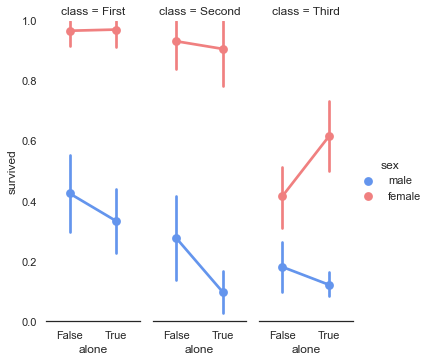

In [61]:
sns.catplot(x="alone",
            y="survived",
            data=titanic,
            hue="sex",
            col="class",
            kind="point",
            palette=pal,
            aspect=0.33).set(ylim=(0, 1)).despine(left=True)